The CIFAR first steps. The following notebook is based on code from kaggle platform:
https://www.kaggle.com/datajameson/cifar-10-object-recognition-cnn-explained

First import all necessary libraries


In [ ]:
# importing libraries
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,ToPILImage
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import CIFAR10

Import dataset

In [ ]:
# set seed
random_seed=123

# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

dataset = CIFAR10('file', download=True, transform=ToTensor())

val_size = 5000
train_size = len(dataset) - val_size
train, val = random_split(dataset,[train_size, val_size],generator=torch.manual_seed(random_seed))
len(train), len(val)


Files already downloaded and verified


(45000, 5000)

In [ ]:
batch_size=128
train = DataLoader(train,batch_size,shuffle=True,num_workers=4,pin_memory=True )
val = DataLoader(val, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions, No padding and no striding
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel) 
    return output

In [ ]:
def accuracy(outputs,labels):
    _,preds= torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels= batch
        out= self(images)  #Generate predictions
        loss= F.cross_entropy(out,labels) #calculate loss
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss= F.cross_entropy(out,labels) # calculate loss
        acc= accuracy(out,labels)
        return {'val_loss':loss.detach(), 'val_acc':acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss= torch.stack(batch_losses).mean() # Stacking losses to combine losses and calculate average
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
        
    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model= Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train = DeviceDataLoader(train, device)
val = DeviceDataLoader(val, device) # load data to  device (GPU if available)
to_device(model, device) # move model to GPU if available

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [ ]:
#In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True.
@torch.no_grad() 
def evaluate(model, val_loader):
    model.eval() # Setting model to evaluation mode, the model can adjust its behavior regarding some operations, like Dropout.
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
  
def fit(epochs, lr, model, train_loader, val_loader, opt_func= torch.optim.SGD):
    history=[]
    optimizer= opt_func(model.parameters(),lr) # model paramters w.r.t calculate derivative of loss
    for epoch in range(epochs):
        # Training phase
        model.train() # Setting model to training mode
        train_losses=[]
        for batch in train_loader:
            loss= model.training_step(batch)
            train_losses.append(loss)
            loss.backward() #compute  gradients
            optimizer.step()
            optimizer.zero_grad() # zero the gradients
        #Validation phase
        result= evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(model, val)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.09648437798023224, 'val_loss': 2.302464008331299}

In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs, lr, model, train, val, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.8509, val_loss: 1.5411, val_acc: 0.4271
Epoch [1], train_loss: 1.3172, val_loss: 1.2097, val_acc: 0.5670
Epoch [2], train_loss: 1.0247, val_loss: 1.0011, val_acc: 0.6482
Epoch [3], train_loss: 0.8446, val_loss: 0.8770, val_acc: 0.6881
Epoch [4], train_loss: 0.6966, val_loss: 0.8387, val_acc: 0.7064
Epoch [5], train_loss: 0.5919, val_loss: 0.7366, val_acc: 0.7451
Epoch [6], train_loss: 0.4954, val_loss: 0.7630, val_acc: 0.7500
Epoch [7], train_loss: 0.4049, val_loss: 0.7293, val_acc: 0.7619
Epoch [8], train_loss: 0.3286, val_loss: 0.8229, val_acc: 0.7572
Epoch [9], train_loss: 0.2654, val_loss: 0.8619, val_acc: 0.7555
Epoch [10], train_loss: 0.2035, val_loss: 0.9236, val_acc: 0.7617
Epoch [11], train_loss: 0.1633, val_loss: 1.0860, val_acc: 0.7426
Epoch [12], train_loss: 0.1505, val_loss: 1.0914, val_acc: 0.7541
Epoch [13], train_loss: 0.1276, val_loss: 1.1351, val_acc: 0.7553
Epoch [14], train_loss: 0.1087, val_loss: 1.2241, val_acc: 0.7564


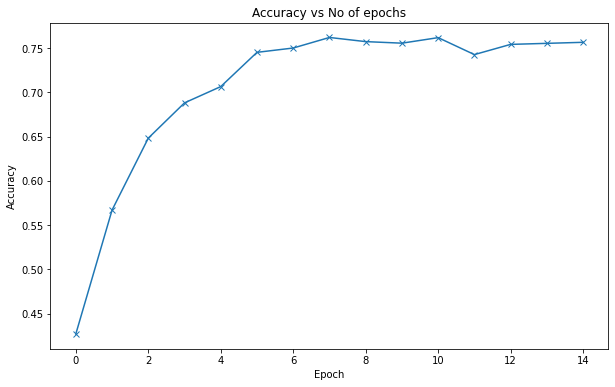

In [ ]:
def plot_accuracies(history):
    accuracies=[x['val_acc'] for x in history]
    plt.plot(accuracies,'-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs No of epochs')

plt.figure(figsize=(10,6))
plot_accuracies(history)

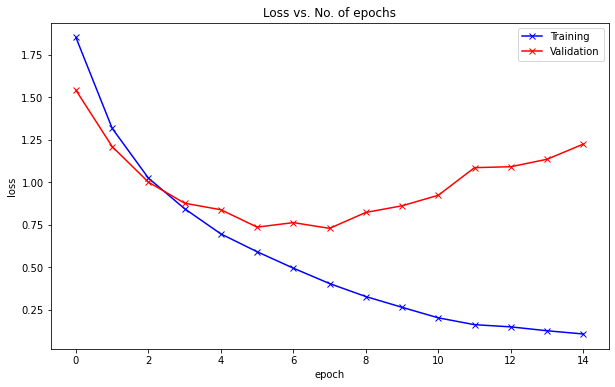

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plt.figure(figsize=(10,6))
plot_losses(history)